<a href="https://colab.research.google.com/github/seansothey/CSC685/blob/master/CNN_Hyperparameters_Keras_Tuner_Coil100_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Images Classification With Convolutional Neural Networks

![alt text](https://www1.cs.columbia.edu/CAVE/software/softlib/gif/100objects.jpg)

**Datasets:**

Coil-100: The dataset contains 7200 color images of 100 objects (72 images per object). Total file size is 124 MB.  
https://www.cs.columbia.edu/CAVE/software/softlib/coil-100.php


**Machine Learning Techniques:**

*   CNN Basic Model
*   CNN Tuning Hyperparameters with **KerasTuner**
*   CNN Tuning Hyperparameters with **ResNet**



##Setup

In [1]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=acc880dd448ecd10994bca6f4f1bee82c42c3e68f650be4a8461d2fd44fb394e
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=d6c1e8f593486fa45f74baaf40e3d2bb5b4555cf6a1a1e4f53f5d31b2b1880ad
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
# Common Import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

# Scikit Learn libraries
import sklearn
from sklearn import metrics

# Others
import os
from zipfile import ZipFile
import zipfile
import tarfile
import cv2
import random
from google.colab.patches import cv2_imshow

# To make this notebook's output stable across runs
np.random.seed(168)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# If not update sklearn -> !pip install -U scikit-learn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'0.22.2.post1'

## Custom Functions

Downloading data to a specific path

In [0]:
import urllib
import urllib.parse as parse

def download(url, save_path, target_file_name=''):
  print("Downloading ...")
  file = urllib.request.urlopen(url)
  fileData = file.read()

  if target_file_name=='':
    split=parse.urlsplit(url)
    target_file_name = split.path.split('/')[-1]
  
  if not os.path.exists(save_path):
    os.mkdir(save_path)

  targetFile = os.path.join(save_path, target_file_name)
  with open(targetFile, 'wb') as f:
    f.write(fileData)
  print('Done, file in the path {}'.format(targetFile))

Extract zip file

In [0]:
def extractZip(zip_file_path, target_path):
    print("Start extracting....")
    zFile=ZipFile(zip_file_path)
    zFile.extractall(target_path)
    zFile.close()
    print("Done")

Extract tar file

In [0]:
def extractTar(tar_file_path, target_path):
    print("Start extracting....")
    tar=tarfile.open(tar_file_path)
    tar.extractall(target_path)
    tar.close()
    print("Done")

Create dataset from the data's path that downloaded to

In [0]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path, img))
    img_imr = cv2.resize(img_imr,(128,128)) # resize images if it has to
    x.append(np.array(img_imr))
  return x


###Preprocessing Data

In [7]:
!wget http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip -O /content/coil-100.zip

--2020-05-13 20:09:36--  http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip [following]
--2020-05-13 20:09:36--  https://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130688843 (125M) [application/zip]
Saving to: ‘/content/coil-100.zip’

/content/coil-100.z 100%[===================>] 124.63M  43.3MB/s    in 2.9s    

2020-05-13 20:09:39 (43.3 MB/s) - ‘/content/coil-100.zip’ saved [130688843/130688843]



In [0]:
data_path = '/content/coil-100.zip'
zip_data = zipfile.ZipFile(data_path,'r')
zip_data.extractall('/content/coil100')
zip_data.close()

In [9]:
# Remove files that are not image
coil_dir = '/content/coil100/coil-100'
coil_list = os.listdir(coil_dir)
for item in coil_list:
    if not item.lower().endswith('.png'):
      path = os.path.join(coil_dir, item)
      os.remove(path)
      print('Successfully deleted file in: {}'.format(path))

Successfully deleted file in: /content/coil100/coil-100/convertGroupppm2png.pl~
Successfully deleted file in: /content/coil100/coil-100/convertGroupppm2png.pl


In [0]:
coil_list = os.listdir('/content/coil100/coil-100') # to refresh the folder again

In [11]:
print('Total images:',len(coil_list))

Total images: 7200


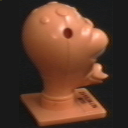

image size (128, 128, 3) 


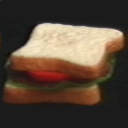

image size (128, 128, 3) 


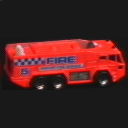

image size (128, 128, 3) 


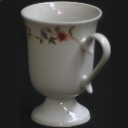

image size (128, 128, 3) 


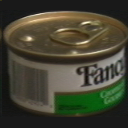

image size (128, 128, 3) 


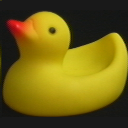

image size (128, 128, 3) 


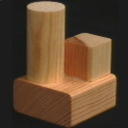

image size (128, 128, 3) 


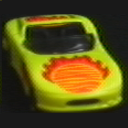

image size (128, 128, 3) 


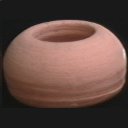

image size (128, 128, 3) 


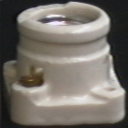

image size (128, 128, 3) 


In [12]:
# Plot to see some images of the dataset
for i in range(10):
  rndIndx = random.randint(0,len(coil_list)-1)
  img = cv2.imread(os.path.join(coil_dir, coil_list[rndIndx]))
  cv2_imshow(img)
  print('image size {} '.format(img.shape))

See the the first 10 images filename

In [13]:
print(coil_list[:10])

['obj80__75.png', 'obj4__330.png', 'obj65__260.png', 'obj84__250.png', 'obj69__165.png', 'obj24__150.png', 'obj69__255.png', 'obj13__215.png', 'obj23__255.png', 'obj59__60.png']


Therefore, the first 4 letters represented the labels of the images

##Create label y

In [0]:
label_name = []
for name in coil_list:
  label_name.append(name.split("j")[1].split("__")[0])

In [15]:
num_classes = len(np.unique(label_name))
num_classes

100

In [0]:
labels = np.asarray(label_name) # convert to array
labels = labels.astype(np.uint8) # convert from array str to array int

In [17]:
labels

array([80,  4, 65, ..., 60, 67, 81], dtype=uint8)

In [0]:
import sklearn.preprocessing
lb = sklearn.preprocessing.LabelBinarizer()
lb.fit(range(max(labels)))
y = lb.transform(labels)

In [0]:
#from keras.utils import to_categorical
#y = to_categorical(labels, num_classes=num_classes)

##Create training X

In [0]:
coil100 = create_img_set(os.path.join(coil_dir))

View some random images

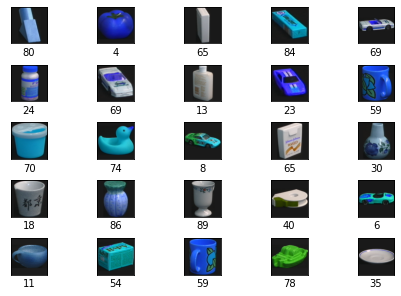

In [21]:
fig, ax = plt.subplots(5, 5, constrained_layout=True)
for i, axi in enumerate(ax.flat):
    axi.imshow(coil100[i])
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(labels[i])

###Flatten dataset

In [22]:
X = np.array(coil100)
X.shape

(7200, 128, 128, 3)

###Scale dataset

In [23]:
np.amin(X), np.amax(X) # see the mix and max value before scale

(0, 253)

Scale to (0,1) by deviding with max. value 253

In [0]:
X =  X.astype('float32')/253.0

In [25]:
np.amin(X), np.amax(X)

(0.0, 1.0)

###Split dataset X and y

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=168)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5760, 128, 128, 3), (1440, 128, 128, 3), (5760, 100), (1440, 100))

#Basic CNN Model

In [28]:
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers, optimizers
np.random.seed(168)

print(tf.__version__)

2.2.0


Using TensorFlow backend.


In [0]:
# Instance 3 layers model
model3 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', strides=(2,2), kernel_regularizer=regularizers.l2(0.01), input_shape=(128,128,3)),  # 1st layer
    MaxPooling2D(pool_size=(2, 2),strides=2),

    Conv2D(32, kernel_size=(3,3), activation='relu', strides=(2,2), kernel_regularizer=regularizers.l2(0.01)), # 2nd layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    BatchNormalization(),

    Conv2D(16, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), # 3rd layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(100, activation='softmax')
])

In [0]:
model3.compile(loss='categorical_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

In [31]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 63, 63, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 16)       

In [32]:
tr3 = model3.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Train on 4608 samples, validate on 1152 samples
Epoch 1/10
4608/4608 [==============================] - 8s 2ms/step - loss: 4.1946 - accuracy: 0.1758 - val_loss: 4.2807 - val_accuracy: 0.2335
Epoch 2/10
4608/4608 [==============================] - 1s 308us/step - loss: 1.7891 - accuracy: 0.6675 - val_loss: 2.2008 - val_accuracy: 0.7595
Epoch 3/10
4608/4608 [==============================] - 1s 315us/step - loss: 1.0455 - accuracy: 0.8485 - val_loss: 0.9929 - val_accuracy: 0.9210
Epoch 4/10
4608/4608 [==============================] - 1s 312us/step - loss: 0.8043 - accuracy: 0.9091 - val_loss: 0.7144 - val_accuracy: 0.9566
Epoch 5/10
4608/4608 [==============================] - 1s 310us/step - loss: 0.6599 - accuracy: 0.9477 - val_loss: 0.7092 - val_accuracy: 0.9288
Epoch 6/10
4608/4608 [==============================] - 1s 321us/step - loss: 0.6081 - accuracy: 0.9546 - val_loss: 0.5337 - val_accuracy: 0.9809
Epoch 7/10
4608/4608 [==============================] - 1s 311us/step - loss: 

In [33]:
score3 = model3.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

Test loss: 0.4582223627302382
Test accuracy: 0.9666666388511658


Wow !!! Impressive accuracy with just the basic model. Let's tune somce hyperparameters to see if we can get a better accuracy.

### Plot the learning curve to see the trend

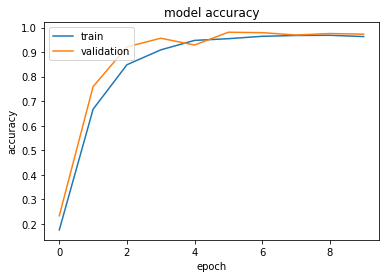

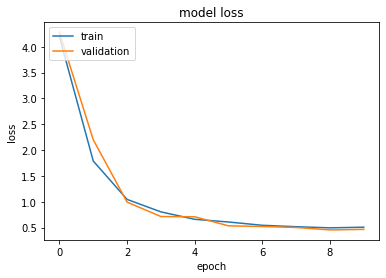

In [34]:
# summarize history for accuracy
plt.plot(tr3.history['accuracy'])
plt.plot(tr3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(tr3.history['loss'])
plt.plot(tr3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

It looks smooth and clean!

##Tuning hyperparameters with KerasTuner

To put the whole hyperparameter search space together and perform hyperparameter tuning, Keras Tuners uses `HyperModel` instances. Hypermodels are reusable class object introduced with the library, defined as follows:

In [0]:
from kerastuner import HyperModel

class MyHyperModel(HyperModel):

  def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

  def build(self, hp):
  
    model = keras.Sequential([
    # 1st layer
    keras.layers.Conv2D(
        filters=hp.Choice('filter1', values=[16,32,64]), 
        kernel_size=hp.Choice('kernel_1', values=[3,5]), 
        strides=hp.Choice('stride1', values=[1,2,3]), 
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01),
        input_shape=self.input_shape
    ),
    keras.layers.MaxPool2D(pool_size=hp.Choice('pool_size1', values=[1,2]),   
                           strides=hp.Choice('stride_pool1', values=[1,2])),

    # 2nd layer
    keras.layers.Conv2D(
        filters=hp.Choice('filter1', values=[16,32,64]),
        kernel_size=hp.Choice('kernel_2', values=[3,5]),
        strides=hp.Choice('stride2', values=[1,2,3]),
        activation='relu', 
        kernel_regularizer=keras.regularizers.l2(0.01)
    ),
    keras.layers.MaxPool2D(pool_size=hp.Choice('pool_size2', values=[1,2]),
                           strides=hp.Choice('stride_pool2', values=[1,2])),

    # 3rd layer
    keras.layers.Conv2D(
        filters=hp.Choice('filter1', values=[16,32,64]),
        kernel_size=hp.Choice('kernel_3', values=[3,5]),
        strides=hp.Choice('stride3', values=[1,2,3]),
        activation='relu', 
        kernel_regularizer=keras.regularizers.l2(0.01)
    ),
    keras.layers.MaxPool2D(pool_size=hp.Choice('pool_size3', values=[1,2]),
                           strides=hp.Choice('stride_pool3', values=[1,2])),
                            
    keras.layers.Dropout(rate=hp.Float('drop_rate', min_value=0.05, max_value=0.25, step=0.05)),

    keras.layers.Flatten(),

    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=256, max_value=1024, step=64),
        activation=hp.Choice('activation1', values=['relu', 'tanh', 'sigmoid'])
    ),

    keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=100, max_value=512, step=32),
        activation=hp.Choice('activation1', values=['relu', 'tanh', 'sigmoid'])
    ),

    keras.layers.Dense(self.num_classes, activation='softmax')
  ])
  
    model.compile(optimizer=keras.optimizers.SGD(hp.Choice('learning_rate', values=[0.001, 0.0025, 0.005, 0.01])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
    return model

In [0]:
hypermodel = MyHyperModel(input_shape=(128,128,3), num_classes=100)

###Search for the best hyperparameters using 5 trials only

In [0]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [0]:
tuner_RS = RandomSearch(
    hypermodel,
    objective='val_accuracy', 
    max_trials=5, 
    executions_per_trial=2,
    directory='RandomSearch',
    project_name='Coil-100') 

In [39]:
tuner_RS.search(X_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5
144/144 [==============================] - 1s 10ms/step - loss: 4.9211 - accuracy: 0.0095 - val_loss: 4.9373 - val_accuracy: 0.0087
Epoch 2/5
144/144 [==============================] - 1s 7ms/step - loss: 4.9173 - accuracy: 0.0089 - val_loss: 4.9338 - val_accuracy: 0.0087
Epoch 3/5
144/144 [==============================] - 1s 7ms/step - loss: 4.9134 - accuracy: 0.0102 - val_loss: 4.9304 - val_accuracy: 0.0104
Epoch 4/5
144/144 [==============================] - 1s 7ms/step - loss: 4.9096 - accuracy: 0.0109 - val_loss: 4.9269 - val_accuracy: 0.0130
Epoch 5/5
144/144 [==============================] - 1s 7ms/step - loss: 4.9069 - accuracy: 0.0109 - val_loss: 4.9235 - val_accuracy: 0.0148
Epoch 1/5
144/144 [==============================] - 1s 9ms/step - loss: 4.9173 - accuracy: 0.0239 - val_loss: 4.9382 - val_accuracy: 0.0260
Epoch 2/5
144/144 [==============================] - 1s 7ms/step - loss: 4.9150 - accuracy: 0.0245 - val_loss: 4.9360 - val_accuracy: 0.0200
Epoch 3/5
14

Epoch 1/5
144/144 [==============================] - 3s 18ms/step - loss: 5.8845 - accuracy: 0.0132 - val_loss: 5.8980 - val_accuracy: 0.0139
Epoch 2/5
144/144 [==============================] - 2s 17ms/step - loss: 5.8678 - accuracy: 0.0141 - val_loss: 5.8820 - val_accuracy: 0.0148
Epoch 3/5
144/144 [==============================] - 3s 17ms/step - loss: 5.8498 - accuracy: 0.0180 - val_loss: 5.8625 - val_accuracy: 0.0156
Epoch 4/5
144/144 [==============================] - 3s 17ms/step - loss: 5.8273 - accuracy: 0.0191 - val_loss: 5.8368 - val_accuracy: 0.0252
Epoch 5/5
144/144 [==============================] - 3s 17ms/step - loss: 5.7941 - accuracy: 0.0317 - val_loss: 5.7983 - val_accuracy: 0.0408
Epoch 1/5
144/144 [==============================] - 3s 18ms/step - loss: 5.8827 - accuracy: 0.0059 - val_loss: 5.8919 - val_accuracy: 0.0035
Epoch 2/5
144/144 [==============================] - 2s 16ms/step - loss: 5.8617 - accuracy: 0.0087 - val_loss: 5.8700 - val_accuracy: 0.0139
Epoch 

Epoch 1/5
144/144 [==============================] - 1s 9ms/step - loss: 5.2174 - accuracy: 0.0208 - val_loss: 5.1953 - val_accuracy: 0.0321
Epoch 2/5
144/144 [==============================] - 1s 7ms/step - loss: 5.0878 - accuracy: 0.0419 - val_loss: 4.9646 - val_accuracy: 0.0443
Epoch 3/5
144/144 [==============================] - 1s 7ms/step - loss: 4.5734 - accuracy: 0.1016 - val_loss: 4.0832 - val_accuracy: 0.2292
Epoch 4/5
144/144 [==============================] - 1s 7ms/step - loss: 3.7221 - accuracy: 0.2637 - val_loss: 3.2049 - val_accuracy: 0.4427
Epoch 5/5
144/144 [==============================] - 1s 7ms/step - loss: 3.0634 - accuracy: 0.4262 - val_loss: 2.5974 - val_accuracy: 0.5668
Epoch 1/5
144/144 [==============================] - 1s 9ms/step - loss: 5.2227 - accuracy: 0.0095 - val_loss: 5.2174 - val_accuracy: 0.0113
Epoch 2/5
144/144 [==============================] - 1s 7ms/step - loss: 5.1515 - accuracy: 0.0217 - val_loss: 5.1160 - val_accuracy: 0.0243
Epoch 3/5
144

Epoch 1/5
144/144 [==============================] - 1s 9ms/step - loss: 5.8868 - accuracy: 0.0115 - val_loss: 5.8984 - val_accuracy: 0.0122
Epoch 2/5
144/144 [==============================] - 1s 8ms/step - loss: 5.8674 - accuracy: 0.0126 - val_loss: 5.8789 - val_accuracy: 0.0139
Epoch 3/5
144/144 [==============================] - 1s 7ms/step - loss: 5.8479 - accuracy: 0.0150 - val_loss: 5.8597 - val_accuracy: 0.0139
Epoch 4/5
144/144 [==============================] - 1s 7ms/step - loss: 5.8285 - accuracy: 0.0163 - val_loss: 5.8408 - val_accuracy: 0.0165
Epoch 5/5
144/144 [==============================] - 1s 7ms/step - loss: 5.8099 - accuracy: 0.0178 - val_loss: 5.8222 - val_accuracy: 0.0191
Epoch 1/5
144/144 [==============================] - 1s 9ms/step - loss: 5.8858 - accuracy: 0.0076 - val_loss: 5.8978 - val_accuracy: 0.0035
Epoch 2/5
144/144 [==============================] - 1s 7ms/step - loss: 5.8659 - accuracy: 0.0104 - val_loss: 5.8781 - val_accuracy: 0.0035
Epoch 3/5
144

Epoch 1/5
144/144 [==============================] - 3s 24ms/step - loss: 5.8489 - accuracy: 0.0193 - val_loss: 5.8087 - val_accuracy: 0.0260
Epoch 2/5
144/144 [==============================] - 3s 22ms/step - loss: 5.4702 - accuracy: 0.0679 - val_loss: 4.7045 - val_accuracy: 0.1649
Epoch 3/5
144/144 [==============================] - 3s 22ms/step - loss: 3.9669 - accuracy: 0.3105 - val_loss: 3.0523 - val_accuracy: 0.5512
Epoch 4/5
144/144 [==============================] - 3s 22ms/step - loss: 2.6436 - accuracy: 0.6283 - val_loss: 2.1588 - val_accuracy: 0.7378
Epoch 5/5
144/144 [==============================] - 3s 22ms/step - loss: 1.9809 - accuracy: 0.7908 - val_loss: 1.8864 - val_accuracy: 0.8307
Epoch 1/5
144/144 [==============================] - 3s 23ms/step - loss: 5.8427 - accuracy: 0.0293 - val_loss: 5.7903 - val_accuracy: 0.0495
Epoch 2/5
144/144 [==============================] - 3s 21ms/step - loss: 5.4469 - accuracy: 0.0751 - val_loss: 4.7236 - val_accuracy: 0.1849
Epoch 

INFO:tensorflow:Oracle triggered exit


In [0]:
 model_RS = tuner_RS.get_best_models(num_models=1)[0]

Here's the best model

In [41]:
model_RS.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 59, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 64)        0

Fit the training set to the best model once again to verify

In [42]:
model_RS.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
144/144 [==============================] - 3s 23ms/step - loss: 1.6309 - accuracy: 0.8704 - val_loss: 1.4979 - val_accuracy: 0.9089
Epoch 2/10
144/144 [==============================] - 3s 21ms/step - loss: 1.4147 - accuracy: 0.9234 - val_loss: 1.3670 - val_accuracy: 0.9245
Epoch 3/10
144/144 [==============================] - 3s 21ms/step - loss: 1.3080 - accuracy: 0.9449 - val_loss: 1.2399 - val_accuracy: 0.9566
Epoch 4/10
144/144 [==============================] - 3s 21ms/step - loss: 1.2207 - accuracy: 0.9579 - val_loss: 1.2371 - val_accuracy: 0.9557
Epoch 5/10
144/144 [==============================] - 3s 21ms/step - loss: 1.1642 - accuracy: 0.9685 - val_loss: 1.1224 - val_accuracy: 0.9826
Epoch 6/10
144/144 [==============================] - 3s 21ms/step - loss: 1.1837 - accuracy: 0.9588 - val_loss: 1.0818 - val_accuracy: 0.9852
Epoch 7/10
144/144 [==============================] - 3s 22ms/step - loss: 1.0701 - accuracy: 0.9798 - val_loss: 1.0892 - val_accuracy: 0.9731

See the accuracy

In [43]:
score_model_RS = model_RS.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_model_RS[0])
print('Test accuracy:', score_model_RS[1])

Test loss: 1.1133856773376465
Test accuracy: 0.9506944417953491


Oops, it's getting worse with **RandomSearch** tuning model

##Tuning with Hyperband

In [0]:
from kerastuner.tuners import Hyperband

tuner_HB = Hyperband(
    hypermodel,
    objective='val_accuracy', 
    max_epochs=5,
    executions_per_trial=2,
    directory='Hyperband',
    project_name='Coil-100')

In [45]:
tuner_HB.search(X_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/2
144/144 [==============================] - 1s 9ms/step - loss: 5.2450 - accuracy: 0.0093 - val_loss: 5.2604 - val_accuracy: 0.0113
Epoch 2/2
144/144 [==============================] - 1s 7ms/step - loss: 5.2337 - accuracy: 0.0100 - val_loss: 5.2493 - val_accuracy: 0.0113
Epoch 1/2
144/144 [==============================] - 1s 9ms/step - loss: 5.2442 - accuracy: 0.0113 - val_loss: 5.2601 - val_accuracy: 0.0104
Epoch 2/2
144/144 [==============================] - 1s 7ms/step - loss: 5.2331 - accuracy: 0.0115 - val_loss: 5.2494 - val_accuracy: 0.0130


Epoch 1/2
144/144 [==============================] - 1s 9ms/step - loss: 4.9056 - accuracy: 0.0115 - val_loss: 4.8944 - val_accuracy: 0.0113
Epoch 2/2
144/144 [==============================] - 1s 8ms/step - loss: 4.8036 - accuracy: 0.0211 - val_loss: 4.6075 - val_accuracy: 0.0460
Epoch 1/2
144/144 [==============================] - 1s 9ms/step - loss: 4.9117 - accuracy: 0.0098 - val_loss: 4.9120 - val_accuracy: 0.0156
Epoch 2/2
144/144 [==============================] - 1s 8ms/step - loss: 4.8544 - accuracy: 0.0128 - val_loss: 4.7993 - val_accuracy: 0.0061


Epoch 1/2
144/144 [==============================] - 1s 9ms/step - loss: 5.8930 - accuracy: 0.0069 - val_loss: 5.9083 - val_accuracy: 0.0182
Epoch 2/2
144/144 [==============================] - 1s 7ms/step - loss: 5.8844 - accuracy: 0.0111 - val_loss: 5.8999 - val_accuracy: 0.0122
Epoch 1/2
144/144 [==============================] - 1s 9ms/step - loss: 5.8920 - accuracy: 0.0089 - val_loss: 5.9098 - val_accuracy: 0.0130
Epoch 2/2
144/144 [==============================] - 1s 7ms/step - loss: 5.8830 - accuracy: 0.0087 - val_loss: 5.9011 - val_accuracy: 0.0130


Epoch 1/2
144/144 [==============================] - 2s 13ms/step - loss: 5.8115 - accuracy: 0.0226 - val_loss: 5.7400 - val_accuracy: 0.0269
Epoch 2/2
144/144 [==============================] - 2s 11ms/step - loss: 5.3084 - accuracy: 0.1096 - val_loss: 4.6138 - val_accuracy: 0.2535
Epoch 1/2
144/144 [==============================] - 2s 13ms/step - loss: 5.7840 - accuracy: 0.0339 - val_loss: 5.5987 - val_accuracy: 0.0712
Epoch 2/2
144/144 [==============================] - 2s 12ms/step - loss: 4.8968 - accuracy: 0.1997 - val_loss: 4.0950 - val_accuracy: 0.3811


Epoch 1/2
144/144 [==============================] - 2s 11ms/step - loss: 6.0334 - accuracy: 0.0111 - val_loss: 6.0661 - val_accuracy: 0.0069
Epoch 2/2
144/144 [==============================] - 1s 9ms/step - loss: 5.9922 - accuracy: 0.0111 - val_loss: 6.0280 - val_accuracy: 0.0069
Epoch 1/2
144/144 [==============================] - 2s 11ms/step - loss: 6.0378 - accuracy: 0.0085 - val_loss: 6.0281 - val_accuracy: 0.0113
Epoch 2/2
144/144 [==============================] - 1s 9ms/step - loss: 5.9956 - accuracy: 0.0082 - val_loss: 5.9938 - val_accuracy: 0.0113


Epoch 3/5
144/144 [==============================] - 2s 13ms/step - loss: 5.8192 - accuracy: 0.0206 - val_loss: 5.7265 - val_accuracy: 0.0269
Epoch 4/5
144/144 [==============================] - 2s 11ms/step - loss: 5.2136 - accuracy: 0.1270 - val_loss: 4.5086 - val_accuracy: 0.2700
Epoch 5/5
144/144 [==============================] - 2s 11ms/step - loss: 3.9740 - accuracy: 0.3969 - val_loss: 3.3868 - val_accuracy: 0.5634
Epoch 3/5
144/144 [==============================] - 2s 13ms/step - loss: 5.8143 - accuracy: 0.0276 - val_loss: 5.6884 - val_accuracy: 0.0460
Epoch 4/5
144/144 [==============================] - 2s 11ms/step - loss: 5.0790 - accuracy: 0.1452 - val_loss: 4.3040 - val_accuracy: 0.3351
Epoch 5/5
144/144 [==============================] - 2s 11ms/step - loss: 3.7653 - accuracy: 0.4735 - val_loss: 3.1275 - val_accuracy: 0.6476


Epoch 3/5
144/144 [==============================] - 1s 9ms/step - loss: 4.9110 - accuracy: 0.0093 - val_loss: 4.9187 - val_accuracy: 0.0095
Epoch 4/5
144/144 [==============================] - 1s 8ms/step - loss: 4.8725 - accuracy: 0.0128 - val_loss: 4.8612 - val_accuracy: 0.0113
Epoch 5/5
144/144 [==============================] - 1s 8ms/step - loss: 4.6934 - accuracy: 0.0280 - val_loss: 4.4297 - val_accuracy: 0.0720
Epoch 3/5
144/144 [==============================] - 1s 10ms/step - loss: 4.9045 - accuracy: 0.0115 - val_loss: 4.8982 - val_accuracy: 0.0061
Epoch 4/5
144/144 [==============================] - 1s 8ms/step - loss: 4.8191 - accuracy: 0.0195 - val_loss: 4.7211 - val_accuracy: 0.0286
Epoch 5/5
144/144 [==============================] - 1s 8ms/step - loss: 4.3517 - accuracy: 0.0690 - val_loss: 3.6391 - val_accuracy: 0.1806


Epoch 1/5
144/144 [==============================] - 1s 9ms/step - loss: 5.2565 - accuracy: 0.0109 - val_loss: 5.2745 - val_accuracy: 0.0113
Epoch 2/5
144/144 [==============================] - 1s 7ms/step - loss: 5.2512 - accuracy: 0.0111 - val_loss: 5.2690 - val_accuracy: 0.0104
Epoch 3/5
144/144 [==============================] - 1s 7ms/step - loss: 5.2446 - accuracy: 0.0132 - val_loss: 5.2637 - val_accuracy: 0.0104
Epoch 4/5
144/144 [==============================] - 1s 8ms/step - loss: 5.2389 - accuracy: 0.0130 - val_loss: 5.2586 - val_accuracy: 0.0104
Epoch 5/5
144/144 [==============================] - 1s 8ms/step - loss: 5.2340 - accuracy: 0.0135 - val_loss: 5.2536 - val_accuracy: 0.0104
Epoch 1/5
144/144 [==============================] - 1s 9ms/step - loss: 5.2416 - accuracy: 0.0156 - val_loss: 5.2622 - val_accuracy: 0.0252
Epoch 2/5
144/144 [==============================] - 1s 8ms/step - loss: 5.2367 - accuracy: 0.0176 - val_loss: 5.2565 - val_accuracy: 0.0304
Epoch 3/5
144

Epoch 1/5
144/144 [==============================] - 4s 28ms/step - loss: 5.1185 - accuracy: 0.0421 - val_loss: 4.8609 - val_accuracy: 0.0642
Epoch 2/5
144/144 [==============================] - 4s 26ms/step - loss: 4.0996 - accuracy: 0.2487 - val_loss: 3.3311 - val_accuracy: 0.4410
Epoch 3/5
144/144 [==============================] - 4s 31ms/step - loss: 2.9052 - accuracy: 0.5543 - val_loss: 2.3941 - val_accuracy: 0.6858
Epoch 4/5
144/144 [==============================] - 4s 26ms/step - loss: 2.1863 - accuracy: 0.7428 - val_loss: 1.8818 - val_accuracy: 0.7917
Epoch 5/5
144/144 [==============================] - 4s 26ms/step - loss: 1.7434 - accuracy: 0.8422 - val_loss: 1.5732 - val_accuracy: 0.8550
Epoch 1/5
144/144 [==============================] - 4s 26ms/step - loss: 4.9531 - accuracy: 0.0744 - val_loss: 4.4002 - val_accuracy: 0.1753
Epoch 2/5
144/144 [==============================] - 4s 25ms/step - loss: 3.6296 - accuracy: 0.3698 - val_loss: 2.9714 - val_accuracy: 0.5208
Epoch 

Epoch 1/5
144/144 [==============================] - 3s 23ms/step - loss: 5.4077 - accuracy: 0.0104 - val_loss: 5.4088 - val_accuracy: 0.0069
Epoch 2/5
144/144 [==============================] - 3s 19ms/step - loss: 5.3406 - accuracy: 0.0104 - val_loss: 5.3582 - val_accuracy: 0.0069
Epoch 3/5
144/144 [==============================] - 3s 19ms/step - loss: 5.3000 - accuracy: 0.0104 - val_loss: 5.3259 - val_accuracy: 0.0069
Epoch 4/5
144/144 [==============================] - 3s 19ms/step - loss: 5.2730 - accuracy: 0.0102 - val_loss: 5.3037 - val_accuracy: 0.0069
Epoch 5/5
144/144 [==============================] - 3s 20ms/step - loss: 5.2539 - accuracy: 0.0111 - val_loss: 5.2876 - val_accuracy: 0.0069
Epoch 1/5
144/144 [==============================] - 3s 23ms/step - loss: 5.4137 - accuracy: 0.0102 - val_loss: 5.4075 - val_accuracy: 0.0078
Epoch 2/5
144/144 [==============================] - 3s 24ms/step - loss: 5.3474 - accuracy: 0.0106 - val_loss: 5.3585 - val_accuracy: 0.0104
Epoch 

INFO:tensorflow:Oracle triggered exit


In [0]:
 model_HB = tuner_HB.get_best_models(num_models=1)[0]

Here's the best model

In [47]:
model_HB.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 40, 32)        0

Fit the training set to the best model once again to verify

In [48]:
model_HB.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
144/144 [==============================] - 4s 27ms/step - loss: 1.3757 - accuracy: 0.9060 - val_loss: 1.2629 - val_accuracy: 0.9167
Epoch 2/10
144/144 [==============================] - 4s 25ms/step - loss: 1.2222 - accuracy: 0.9314 - val_loss: 1.1538 - val_accuracy: 0.9366
Epoch 3/10
144/144 [==============================] - 4s 25ms/step - loss: 1.1187 - accuracy: 0.9497 - val_loss: 1.0644 - val_accuracy: 0.9479
Epoch 4/10
144/144 [==============================] - 4s 25ms/step - loss: 1.0359 - accuracy: 0.9581 - val_loss: 1.0094 - val_accuracy: 0.9549
Epoch 5/10
144/144 [==============================] - 4s 25ms/step - loss: 0.9735 - accuracy: 0.9655 - val_loss: 0.9464 - val_accuracy: 0.9644
Epoch 6/10
144/144 [==============================] - 4s 25ms/step - loss: 0.9229 - accuracy: 0.9724 - val_loss: 0.9003 - val_accuracy: 0.9714
Epoch 7/10
144/144 [==============================] - 4s 25ms/step - loss: 0.8821 - accuracy: 0.9759 - val_loss: 0.8698 - val_accuracy: 0.9696

See the accuracy

In [49]:
score_model_HB = model_HB.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_model_HB[0])
print('Test accuracy:', score_model_HB[1])

Test loss: 0.7914599180221558
Test accuracy: 0.9694444537162781


## *Bravo !!!*

##Tuning with HyperResNet 

In [0]:
from kerastuner.applications import HyperResNet
from kerastuner.tuners import Hyperband

model_rs = HyperResNet(input_shape=(128, 128, 3), classes=100)

tuner_ResNet = Hyperband(
    model_rs,
    objective='val_accuracy', 
    max_epochs=5,
    executions_per_trial=2,  
    directory='ResNet',
    project_name='Coil-100')

In [51]:
tuner_ResNet.search(X_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/2
144/144 [==============================] - 29s 200ms/step - loss: 10.8042 - accuracy: 0.0510 - val_loss: 91896.5859 - val_accuracy: 0.0113
Epoch 2/2
144/144 [==============================] - 26s 179ms/step - loss: 7.1573 - accuracy: 0.2183 - val_loss: 10824.7168 - val_accuracy: 0.0616
Epoch 1/2
144/144 [==============================] - 28s 194ms/step - loss: 10.9247 - accuracy: 0.0213 - val_loss: 158701.0625 - val_accuracy: 0.0113
Epoch 2/2
144/144 [==============================] - 26s 180ms/step - loss: 7.9448 - accuracy: 0.0549 - val_loss: 8.7041 - val_accuracy: 0.1337


Epoch 1/2
144/144 [==============================] - 59s 409ms/step - loss: 4.5498 - accuracy: 0.0332 - val_loss: 4.7032 - val_accuracy: 0.0061
Epoch 2/2
144/144 [==============================] - 52s 362ms/step - loss: 4.0754 - accuracy: 0.0720 - val_loss: 4.7815 - val_accuracy: 0.0104
Epoch 1/2
144/144 [==============================] - 59s 407ms/step - loss: 4.5389 - accuracy: 0.0282 - val_loss: 4.7023 - val_accuracy: 0.0078
Epoch 2/2
144/144 [==============================] - 51s 357ms/step - loss: 4.0532 - accuracy: 0.0881 - val_loss: 4.7814 - val_accuracy: 0.0104


Epoch 1/2
144/144 [==============================] - 13s 92ms/step - loss: 5.9473 - accuracy: 0.0245 - val_loss: 27876.9609 - val_accuracy: 0.0087
Epoch 2/2
144/144 [==============================] - 12s 86ms/step - loss: 3.7856 - accuracy: 0.0723 - val_loss: 53.0190 - val_accuracy: 0.0174
Epoch 1/2
144/144 [==============================] - 13s 88ms/step - loss: 5.5989 - accuracy: 0.0269 - val_loss: 24314.1113 - val_accuracy: 0.0087
Epoch 2/2
144/144 [==============================] - 12s 86ms/step - loss: 3.6378 - accuracy: 0.0751 - val_loss: 36.4185 - val_accuracy: 0.0208


Epoch 1/2
144/144 [==============================] - 47s 323ms/step - loss: 9.2283 - accuracy: 0.0139 - val_loss: 528821.0625 - val_accuracy: 0.0113
Epoch 2/2
144/144 [==============================] - 42s 289ms/step - loss: 4.4041 - accuracy: 0.0217 - val_loss: 332.2875 - val_accuracy: 0.0165
Epoch 1/2
144/144 [==============================] - 46s 316ms/step - loss: 8.7912 - accuracy: 0.0224 - val_loss: 359880.8125 - val_accuracy: 0.0139
Epoch 2/2
144/144 [==============================] - 40s 278ms/step - loss: 3.8028 - accuracy: 0.0516 - val_loss: 114.6275 - val_accuracy: 0.0035


Epoch 1/2
144/144 [==============================] - 33s 229ms/step - loss: 11.1586 - accuracy: 0.0169 - val_loss: 6694739456.0000 - val_accuracy: 0.0078
Epoch 2/2
144/144 [==============================] - 31s 212ms/step - loss: 5.4688 - accuracy: 0.0237 - val_loss: 70244248.0000 - val_accuracy: 0.0139
Epoch 1/2
144/144 [==============================] - 32s 219ms/step - loss: 11.9963 - accuracy: 0.0193 - val_loss: 42469740429443072.0000 - val_accuracy: 0.0087
Epoch 2/2
144/144 [==============================] - 29s 199ms/step - loss: 5.1141 - accuracy: 0.0315 - val_loss: 448065634304.0000 - val_accuracy: 0.0069


Epoch 3/5
144/144 [==============================] - 28s 198ms/step - loss: 11.3252 - accuracy: 0.0310 - val_loss: 8677892.0000 - val_accuracy: 0.0165
Epoch 4/5
144/144 [==============================] - 26s 180ms/step - loss: 7.8557 - accuracy: 0.1061 - val_loss: 2258.9375 - val_accuracy: 0.0365
Epoch 5/5
144/144 [==============================] - 26s 182ms/step - loss: 5.3885 - accuracy: 0.3260 - val_loss: 1.8879 - val_accuracy: 0.4870
Epoch 3/5
144/144 [==============================] - 28s 193ms/step - loss: 11.3582 - accuracy: 0.0250 - val_loss: 486857.3750 - val_accuracy: 0.0104
Epoch 4/5
144/144 [==============================] - 25s 175ms/step - loss: 7.5776 - accuracy: 0.0590 - val_loss: 7086.2876 - val_accuracy: 0.0139
Epoch 5/5
144/144 [==============================] - 25s 175ms/step - loss: 6.0601 - accuracy: 0.2237 - val_loss: 12.7481 - val_accuracy: 0.2856


Epoch 3/5
144/144 [==============================] - 13s 94ms/step - loss: 5.6998 - accuracy: 0.0265 - val_loss: 10855.4023 - val_accuracy: 0.0052
Epoch 4/5
144/144 [==============================] - 12s 86ms/step - loss: 3.5196 - accuracy: 0.1026 - val_loss: 17.0026 - val_accuracy: 0.0208
Epoch 5/5
144/144 [==============================] - 12s 86ms/step - loss: 2.7395 - accuracy: 0.2378 - val_loss: 3.8695 - val_accuracy: 0.1788
Epoch 3/5
144/144 [==============================] - 13s 88ms/step - loss: 6.2281 - accuracy: 0.0174 - val_loss: 7855.4116 - val_accuracy: 0.0052
Epoch 4/5
144/144 [==============================] - 12s 81ms/step - loss: 4.1502 - accuracy: 0.0286 - val_loss: 28.6619 - val_accuracy: 0.0165
Epoch 5/5
144/144 [==============================] - 12s 81ms/step - loss: 3.8677 - accuracy: 0.0362 - val_loss: 35.0252 - val_accuracy: 0.0026


Epoch 1/5
144/144 [==============================] - 28s 198ms/step - loss: 4.5742 - accuracy: 0.0128 - val_loss: 4.6035 - val_accuracy: 0.0130
Epoch 2/5
144/144 [==============================] - 25s 175ms/step - loss: 4.3909 - accuracy: 0.0341 - val_loss: 4.5359 - val_accuracy: 0.0122
Epoch 3/5
144/144 [==============================] - 26s 180ms/step - loss: 4.2568 - accuracy: 0.0690 - val_loss: 4.2215 - val_accuracy: 0.0608
Epoch 4/5
144/144 [==============================] - 26s 182ms/step - loss: 4.1323 - accuracy: 0.1000 - val_loss: 4.1530 - val_accuracy: 0.0694
Epoch 5/5
144/144 [==============================] - 26s 180ms/step - loss: 3.9979 - accuracy: 0.1356 - val_loss: 3.9799 - val_accuracy: 0.0946
Epoch 1/5
144/144 [==============================] - 28s 193ms/step - loss: 4.5880 - accuracy: 0.0176 - val_loss: 4.6041 - val_accuracy: 0.0095
Epoch 2/5
144/144 [==============================] - 25s 174ms/step - loss: 4.4329 - accuracy: 0.0302 - val_loss: 4.5688 - val_accuracy:

Epoch 1/5
144/144 [==============================] - 34s 233ms/step - loss: 4.2620 - accuracy: 0.1042 - val_loss: 5.5125 - val_accuracy: 0.0087
Epoch 2/5
144/144 [==============================] - 28s 194ms/step - loss: 1.9655 - accuracy: 0.5137 - val_loss: 10.5112 - val_accuracy: 0.0087
Epoch 3/5
144/144 [==============================] - 30s 210ms/step - loss: 0.9997 - accuracy: 0.7982 - val_loss: 8.5532 - val_accuracy: 0.2075
Epoch 4/5
144/144 [==============================] - 30s 210ms/step - loss: 0.9242 - accuracy: 0.8125 - val_loss: 3.7430 - val_accuracy: 0.5512
Epoch 5/5
144/144 [==============================] - 30s 211ms/step - loss: 0.4193 - accuracy: 0.8893 - val_loss: 3.0905 - val_accuracy: 0.7040
Epoch 1/5
144/144 [==============================] - 31s 214ms/step - loss: 5.0038 - accuracy: 0.0358 - val_loss: 4.9041 - val_accuracy: 0.0087
Epoch 2/5
144/144 [==============================] - 28s 194ms/step - loss: 3.2626 - accuracy: 0.2376 - val_loss: 303.6017 - val_accura

Epoch 1/5
144/144 [==============================] - 34s 234ms/step - loss: 4.2348 - accuracy: 0.0842 - val_loss: 8.2067 - val_accuracy: 0.0087
Epoch 2/5
144/144 [==============================] - 31s 215ms/step - loss: 1.5777 - accuracy: 0.5430 - val_loss: 13.2701 - val_accuracy: 0.0139
Epoch 3/5
144/144 [==============================] - 31s 213ms/step - loss: 0.5857 - accuracy: 0.8249 - val_loss: 7.7797 - val_accuracy: 0.0729
Epoch 4/5
144/144 [==============================] - 31s 213ms/step - loss: 0.3450 - accuracy: 0.8965 - val_loss: 2.6820 - val_accuracy: 0.5200
Epoch 5/5
144/144 [==============================] - 28s 194ms/step - loss: 0.5035 - accuracy: 0.8641 - val_loss: 18.4402 - val_accuracy: 0.4332
Epoch 1/5
144/144 [==============================] - 31s 217ms/step - loss: 3.5078 - accuracy: 0.1977 - val_loss: 11.3061 - val_accuracy: 0.0087
Epoch 2/5
144/144 [==============================] - 28s 195ms/step - loss: 1.0239 - accuracy: 0.6905 - val_loss: 16.7194 - val_accur

INFO:tensorflow:Oracle triggered exit


Here's the best model

In [0]:
best_ResNet = tuner_ResNet.get_best_models(num_models=1)[0]

Fit the training set to the best model once again to verify

In [53]:
best_ResNet.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
144/144 [==============================] - 31s 214ms/step - loss: 0.3952 - accuracy: 0.8952 - val_loss: 0.9905 - val_accuracy: 0.8299
Epoch 2/10
144/144 [==============================] - 28s 194ms/step - loss: 0.5975 - accuracy: 0.8613 - val_loss: 3.0031 - val_accuracy: 0.5781
Epoch 3/10
144/144 [==============================] - 28s 195ms/step - loss: 1.1811 - accuracy: 0.8203 - val_loss: 27.1618 - val_accuracy: 0.1406
Epoch 4/10
144/144 [==============================] - 28s 195ms/step - loss: 1.9704 - accuracy: 0.7415 - val_loss: 7601.0278 - val_accuracy: 0.0174
Epoch 5/10
144/144 [==============================] - 28s 195ms/step - loss: 1.3197 - accuracy: 0.8060 - val_loss: 4.1632 - val_accuracy: 0.6780
Epoch 6/10
144/144 [==============================] - 28s 195ms/step - loss: 1.8629 - accuracy: 0.7604 - val_loss: 44.5420 - val_accuracy: 0.1710
Epoch 7/10
144/144 [==============================] - 28s 195ms/step - loss: 3.7437 - accuracy: 0.6766 - val_loss: 2271.0051 

See the accuracy

In [54]:
score_ResNet = best_ResNet.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_ResNet[0])
print('Test accuracy:', score_ResNet[1])

Test loss: 2301.990478515625
Test accuracy: 0.4263888895511627


Slightly better than **RandomSearch** but still a loser compare to initial basic model

#Conclusion

Sometimes tuning hyperparameters doesn't always help. And each range of each parameter input for tuning, supposed to be in a good range that could help elevate the model's performance. The best approach is do not worry about building a quick basic model before tuning. This non trivia basic model would give us a sense of chosing hyperparameters' range to search for when perform tuning.  
As we can see in this experiment, **RandomSearch** returned similar accuracy to the basic model; fortunately, **Hyperband** tuning returned slightly better while ResNet was off the track. Therefore; **Hyperband** is the winner for this CNN hyperparameters tuning experiment for Coil-100 dataset. Below is the summary barchart of the accuracies for all models.

![alt text](https://github.com/seansothey/CSC685/blob/master/CNN-Coil100-Report.PNG?raw=true)

#Reference


https://keras-team.github.io/keras-tuner/